# Lending Club Loan Data Analysis : Final Project

## MSIS 2802 - Data Science Analysis with Python

### Submitted By:  Purnima Tripathi and Ekta Ratanpara

<b> About the project: </b> Lending Club enables borrowers to create unsecured personal loans. The loan period is 3 years or 5 years. Investors can search and browse the loan listings on Lending Club's markeptplace select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest.The dataset is directly downloaded by Lending club's site as below:
        https://www.lendingclub.com/info/download-data.action
        
The project anlayses the loan data approved and rejected to gain insights for investors and borrowers. Orginial raw datasets have many features and messy data, each row represent an even of loan which provides many attributes about borrowers and loan event. Project is divided into two phases: 
<ui><li>Phase 1: Data Preparation </li>
<li>Phase 2: Data Analysis</li>
</ui>



# Data Preparation

<b>Importing the libraries</b>

In [1]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import seaborn as sns
%pylab inline
import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
from sklearn.cluster import KMeans
import pydotplus
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('Lending_Club_Accept_Loan_Data.csv',  header=0, low_memory=False)

In [3]:
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,27050.0,27050.0,27050.0,36 months,10.99%,885.46,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,12000.0,12000.0,12000.0,36 months,10.99%,392.81,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,4800.0,4800.0,4800.0,36 months,10.99%,157.13,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,12000.0,12000.0,12000.0,36 months,11.99%,398.52,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,7550.0,7550.0,7550.0,36 months,16.24%,266.34,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


<b>Removing rows that have all null values</b>

In [4]:
df.dropna(how= 'all', inplace= True)

<b>Removing columns that have more than 10% null values </b>

In [5]:
df.dropna(thresh=0.9*len(df), axis=1, inplace= True)   #as the dataset is big and 10% rows accounts for large number

<b> Removing columns having only one unique value </b>

In [6]:
remove_unique1= df.loc[:,df.apply(pd.Series.nunique) == 1].columns.tolist()
df.drop(remove_unique1,axis=1, inplace= True)

<b> In the resultant dataset, we have 60 columns. We will look at the data dictionary to understand all fields and remove the fields that are not useful for the analysis or are after the fact columns. After the fact columns are the ones that tells whether the loan is repaid or not </b>

<b> Lookup Dictionary</b>

Making a lookup table from dataframe column_names, there data types and sample_values(from 1st row)





In [7]:
df_dtypes = pd.DataFrame()
df_dtypes['columns'] = df.dtypes.index
df_dtypes['type'] = df.dtypes.values
df_dtypes['sample_value'] = df.loc[0].values

Loading data dictionary that lending club provides and merging it with previously created table df_dtypes to see the description

In [8]:
dd= pd.read_excel('LCDataDictionary.xlsx')
df_dic = pd.merge(df_dtypes, dd, how='left', left_on=['columns'], right_on=['LoanStatNew'])
df_dic.drop('LoanStatNew',axis=1, inplace= True)

We will examine data dictionary look up table to find out which fields makes sense to be kept related to our analysis. Let's start by analzying 15 fields at a time

In [9]:
df_dic.head(15)

,columns,type,sample_value,Description
0,loan_amnt,float64,27050,The listed amount of the loan applied for by t...
1,funded_amnt,float64,27050,The total amount committed to that loan at tha...
2,funded_amnt_inv,float64,27050,The total amount committed by investors for th...
3,term,object,36 months,The number of payments on the loan. Values are...
4,int_rate,object,10.99%,Interest Rate on the loan
5,installment,float64,885.46,The monthly payment owed by the borrower if th...
6,grade,object,B,LC assigned loan grade
7,sub_grade,object,B2,LC assigned loan subgrade
8,emp_title,object,Team Leadern Customer Ops & Systems,The job title supplied by the Borrower when ap...
9,emp_length,object,10+ years,Employment length in years. Possible values ar...


Funded amount is the amount that is approved by Lending club and put to the marketplace. for above fields, below are the ones that we can remove:

1. funded_amnt_inv	: we are more concerned with what is already borrowed rather than commited 
2. sub_grade: This field has many unique values and is related to grades.
3. emp_title: Does not matter in the decision making for loan repayment.
4. annual_inc: As we are dealiong with approved data, we are not concerned with annual_income.
5. issue_d: Doesn't matter as analysis is not time_series.

    
    

In [10]:
df.drop(['funded_amnt_inv', 'sub_grade', 'emp_title', 'issue_d'],axis=1, inplace= True)

In [11]:
df_dic[15:30]

,columns,type,sample_value,Description
15,pymnt_plan,object,n,Indicates if a payment plan has been put in pl...
16,purpose,object,debt_consolidation,A category provided by the borrower for the lo...
17,title,object,Debt Consolidation,The loan title provided by the borrower
18,zip_code,object,481xx,The first 3 numbers of the zip code provided b...
19,addr_state,object,MI,The state provided by the borrower in the loan...
20,dti,float64,22.87,A ratio calculated using the borrower’s total ...
21,delinq_2yrs,float64,0,The number of 30+ days past-due incidences of ...
22,earliest_cr_line,object,Oct-86,The month the borrower's earliest reported cre...
23,inq_last_6mths,float64,0,The number of inquiries in past 6 months (excl...
24,open_acc,float64,14,The number of open credit lines in the borrowe...


For above fields, below are the ones that we can remove:

1. title: Purpose and title are almost same but title is more verbose and purpose has fewer discrete values
2. zip_code: Analysis is not geographical
3. addr_state: Analysis is not geographical
4. delinq_2yrs: After the fact.
5. earliest_cr_line: This column is misleading as some has years and some doesn't.
6. initial_list_status: The initial listing status of the loan.
7. pymnt_plan: the fields are either Y or N and does'nt provide any insight.
8. inq_last_6mths: after the fact
9. out_prncp: after the fact




In [12]:
df.drop(['title', 'zip_code', 'addr_state','delinq_2yrs','earliest_cr_line','inq_last_6mths','initial_list_status','out_prncp', 'pymnt_plan'],axis=1, inplace= True)

In [13]:
df_dic.loc[31:45]

,columns,type,sample_value,Description
31,out_prncp_inv,float64,0,Remaining outstanding principal for portion of...
32,total_pymnt,float64,31752.5,Payments received to date for total amount funded
33,total_pymnt_inv,float64,31752.5,Payments received to date for portion of total...
34,total_rec_prncp,float64,27050,Principal received to date
35,total_rec_int,float64,4702.53,Interest received to date
36,total_rec_late_fee,float64,0,Late fees received to date
37,recoveries,float64,0,post charge off gross recovery
38,collection_recovery_fee,float64,0,post charge off collection fee
39,last_pymnt_d,object,Jul-16,Last month payment was received
40,last_pymnt_amnt,float64,6074.19,Last total payment amount received


For above fields, below are the ones that we can remove as they are after the fact columns:

1. total_rec_prncp:
2. total_rec_int:
3. total_rec_late_fee:
4. recoveries:
5. collection_recovery_fee:
6. last_pymnt_d:
7. last_pymnt_amnt:
8. last_credit_pull_d:
9. acc_now_delinq:
10. collections_12_mths_ex_med:
11. tax_liens:
12. out_prncp_inv:
13. total_pymnt:
   

In [14]:
df.drop(['total_pymnt_inv', 'collections_12_mths_ex_med','out_prncp_inv','total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'acc_now_delinq'],axis=1, inplace= True)

In [15]:
df_dic.loc[46:]

,columns,type,sample_value,Description
46,bc_util,float64,53.9,Ratio of total current balance to high credit/...
47,chargeoff_within_12_mths,float64,0,Number of charge-offs within 12 months
48,delinq_amnt,float64,0,The past-due amount owed for the accounts on w...
49,mort_acc,float64,4,Number of mortgage accounts.
50,mths_since_recent_bc,float64,16,Months since most recent bankcard account opened.
51,num_bc_sats,float64,4,Number of satisfactory bankcard accounts
52,num_sats,float64,14,Number of satisfactory accounts
53,percent_bc_gt_75,float64,25,Percentage of all bankcard accounts > 75% of l...
54,pub_rec_bankruptcies,float64,0,Number of public record bankruptcies
55,tax_liens,float64,0,Number of tax liens


From the above fields below are the ones that we can remove, most of them are after the fact:

1. bc_util: we are already keeping revol util.
2. chargeoff_within_12_mths:
3. delinq_amnt:
4. hardship_flag:
5. debt_settlement_flag:


In [16]:
df.drop(['bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'hardship_flag', 'debt_settlement_flag'],axis=1, inplace= True)

<b>Our dataset now have 30 columns. Now we will prepare the data by handling missing values and correcting datatypes and numerical value conversion </b>

### Handling missing values

In [17]:
null_counts = df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
loan_amnt                   2
funded_amnt                 2
term                        2
int_rate                    2
installment                 2
grade                       2
emp_length                  2
home_ownership              2
annual_inc                  2
verification_status         2
loan_status                 2
purpose                     2
dti                         2
open_acc                    2
pub_rec                     2
revol_bal                   2
revol_util                127
total_acc                   2
total_pymnt                 2
acc_open_past_24mths     7497
bc_open_to_buy           9027
mort_acc                 7497
mths_since_recent_bc     8830
num_bc_sats             16057
num_sats                16057
percent_bc_gt_75         9030
pub_rec_bankruptcies        2
tax_liens                   2
total_bal_ex_mort        7497
total_bc_limit           7497
dtype: int64


Dropping the columns that has more missing values

In [18]:
df.drop(['num_bc_sats', 'num_sats' ],axis=1, inplace= True)

Now dealing with these missing values we will fill in the values with 0

In [19]:
df.fillna(0, inplace=True)

Interest rate is numeric value converting them to float datatype

In [20]:
df['int_rate']= df['int_rate'].str.replace('%', '').astype(np.float64)

Doing similar for revol_util

In [21]:
df['revol_util']= df['revol_util'].str.replace('%', '').astype(np.float64)

In [22]:
df.fillna(0, inplace=True)

### Decision Variable

#### In our analysis target variable is loan_status that tells us whether the loan was repaid or defaulted 

In [23]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Late (16-30 days)',
       'Late (31-120 days)', 'In Grace Period', 'Default', 0], dtype=object)

In [24]:
df = df[(df["loan_status"] == "Fully Paid") | (df["loan_status"] == "Charged Off")]  

Here we selected only two types of loan_status rows. The column contains seven uniques fields but we need only two things either charged off or fully paid. Considering it as binary classification problem, we will make one column with binary values 


0 ==> Charged Off               


1 ==> Fully Paid


Mapping values and converting them to binary

In [25]:
df['loan_status'] = df.loan_status.replace({'Fully Paid':1.0, 
                                            'Charged Off':0.0
                                            })

### Preparing data for analysis: Converting categorical variables and creating dummy variables

<b>Examining categorical variable</b>

Categorical variable can be defined as ordinal or nominal. Let us examine variables to find out  ordinal and nominal variables and convert them into numeric
<br/>
As per our first assumptions, let's consider below:
<br/>

Ordinal Variable(Where order matters):
    
    1. grade
    2. emp_length
    
Nominal Variable ( assign them random discrete numeric values):
   
    1. term
    2. verification status
    3. home_ownership
    4. Purpose
    

### Ordinal Variables

Grade determines the return and is in order as below:

A < B < C < D < E < F < G ; where < means less riskier than

<b> Grade </b>

In [26]:
df['grade'] = df.grade.replace({ 'A': 1.0,
        'B': 2.0,
        'C': 3.0,
        'D': 4.0,
        'E': 5.0,
        'F': 6.0,
        'G': 7.0}) 

<b> Emp_length </b>

We are assuming that emp_length with value 'n/a' does not have any employment experience.

In [27]:
df.emp_length.unique()

array(['10+ years', '4 years', '2 years', '3 years', '7 years', '6 years',
       '5 years', '1 year', '9 years', '8 years', '< 1 year', 'n/a'], dtype=object)

In [28]:
df['emp_length'] = df.emp_length.replace({'10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0,
        'n/a': 0})

<b> term: Term is categorical variable as it has two values possible </b>

In [29]:
df.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [30]:
df['term'] = df.term.replace({' 36 months': 0.0, ' 60 months': 1.0})

<b> verification_status </b>

Verification status determines if income was verified by LC or not. We consider it as an important factor as per below reasoning and is in order as below:

Since verified or source verified means the same we can consider it as binary classification either verified or not verified.

0 ==> Not Verified
1 ==> Source Verified, Verified

In [31]:
df['verification_status'] = df.verification_status.replace({ 'Not Verified': 0.0,'Source Verified': 1.0,'Verified': 1.0 })

<b> Home_ownership </b>

In [32]:
df.groupby('home_ownership')['home_ownership'].count()

home_ownership
MORTGAGE    91326
NONE           40
OTHER          45
OWN         14739
RENT        72970
Name: home_ownership, dtype: int64

Looking at the above observation we can remove data for  None and other as we don't know what does it mean'

In [33]:
df_h = pd.get_dummies(df, columns= ['home_ownership'])

Dropping NONE and OTHER from homw ownership

In [34]:
df_h.drop(['home_ownership_NONE', 'home_ownership_OTHER'], axis=1, inplace= True)

<b> Purpose </b>

Purpose is Nominal value, assigning them random numbers

In [35]:
df.purpose.unique()

array(['debt_consolidation', 'home_improvement', 'credit_card', 'other',
       'major_purchase', 'small_business', 'house', 'moving', 'medical',
       'car', 'vacation', 'renewable_energy', 'wedding'], dtype=object)

In [36]:
df_purpose= pd.get_dummies(df_h, columns= ['purpose'])

### Final Dataframe to work with

In [37]:
df_clean= df_purpose          #Saving the final cleaned dataset for Analysis
df_clean.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,annual_inc,verification_status,loan_status,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,27050.0,27050.0,0.0,10.99,885.46,2.0,10,55000.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,12000.0,12000.0,0.0,10.99,392.81,2.0,4,60000.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,4800.0,4800.0,0.0,10.99,157.13,2.0,2,39600.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,0
3,12000.0,12000.0,0.0,11.99,398.52,2.0,10,130000.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,7550.0,7550.0,0.0,16.24,266.34,3.0,3,28000.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


# Data Analysis

## Feature Exploration

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12717be50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12273a090>]], dtype=object)

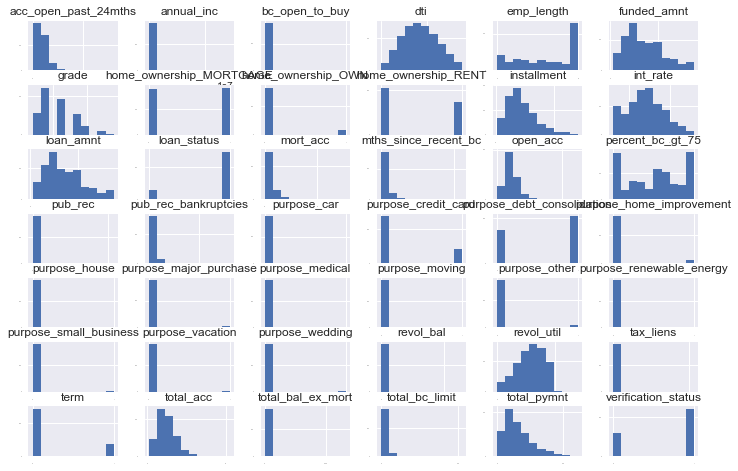

In [38]:
# Histogram
df_clean.hist(sharex=False, sharey=False, xlabelsize=1, figsize= (12,8),ylabelsize=1)
plt.show()

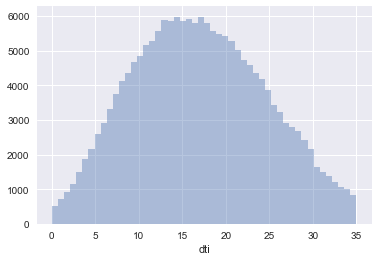

In [39]:
import seaborn as sns
sns.distplot(df_clean['dti'], kde=False)           #distribution for dti

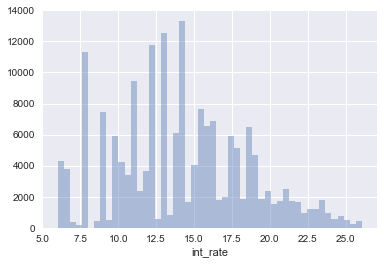

In [40]:
import seaborn as sns
sns.distplot(df_clean['int_rate'], kde=False) 

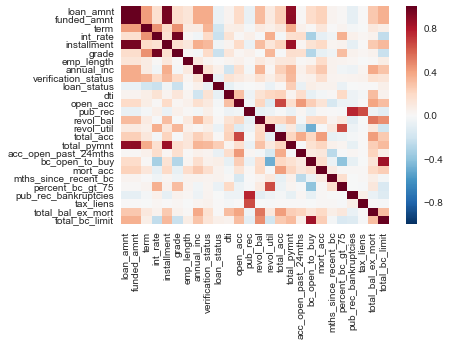

In [41]:
corr = df.corr()
sns.heatmap(corr, )

Some of the correlations are obvious and related as they are derived from it.

## Building a linear Model

In [42]:
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import linear_model

/Users/purnima.tripathi/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [43]:
df_h.drop('purpose', inplace=True, axis=1)          #removing purpose as it will create so many numerical values

In [44]:
df_target= df_h.drop(['loan_status'], axis=1)
y = df_h.loan_status                                  # define the target variable (dependent variable) as y

In [45]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df_target, y, test_size=0.2)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(143296, 28) (143296,)
(35824, 28) (35824,)


In [46]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

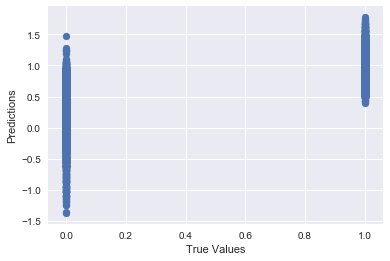

In [47]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [48]:
print 'Score:', model.score(X_test, y_test)

Score: 0.535546475453



# Finding 1: Classification : Desicion Tree

In [49]:
df_dt= df_purpose.drop(['annual_inc','grade','total_pymnt','int_rate','bc_open_to_buy'], axis=1)

In [50]:
dt = tree.DecisionTreeClassifier(max_depth=2)
X = df_dt.drop(['loan_status'], axis=1)
Y = df_dt['loan_status']
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

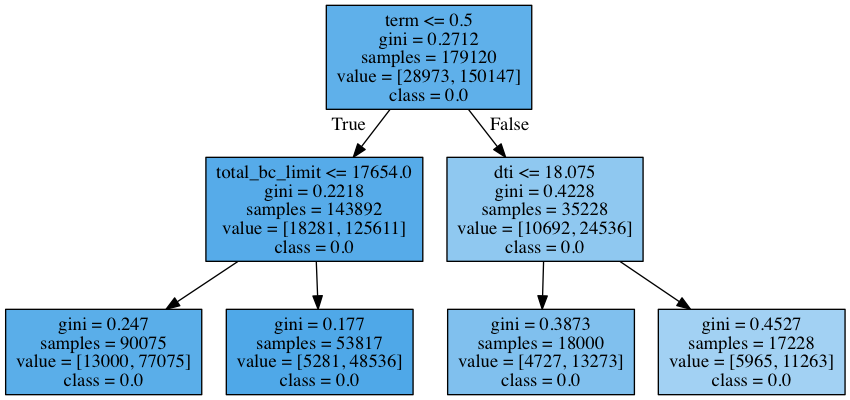

In [51]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

# Finding: 
## Chances of a loan to be defaulted is more in long term than short term, also short term loans are almost independent of debt to income ratio but dti influences the default rate for long term loans.

<b> Validation </b>

In [52]:
df_clean['dti_bin'] = pd.cut(df_clean['dti'],bins=[0,5,10,15,20,25,30,35,100]) 

We can validate our finding based on the graph below that debt to income ratio has higher influence on long term loans than short term loans.

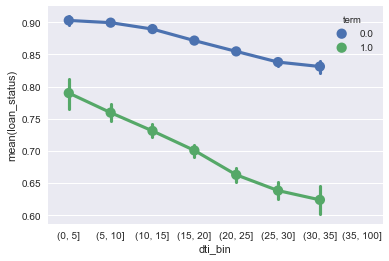

In [53]:
sns.pointplot(x="dti_bin", y="loan_status", hue="term",data=df_clean, aspect =4);

# Finding 2: Regression for ROI

### All investors will expect returns on their investments. 
### Lets find out the areas where you should opt/avoid investment for maximum returns. 
### We are using decision tree regreesor to find what factors contribute to get maximum/minimum ROI.

In [54]:
# calculate ROI based on total payment and funded amount.
def return_on_investement(df_clean):
    df_clean['ROI'] = ((((df_clean.total_pymnt) - df_clean.funded_amnt) / df_clean.funded_amnt) * 100.0)
    return df_clean
df_clean = df_clean.apply(lambda df_clean: return_on_investement(df_clean), axis=1)

In [55]:
df_completed_loans = df_clean.copy(deep=True)

Dropping ROI depended columns

In [56]:
columns = ['total_pymnt','loan_status','int_rate','loan_amnt','dti_bin','acc_open_past_24mths','funded_amnt','annual_inc','mths_since_recent_bc']
df_completed_loans.drop(columns, inplace=True, axis=1)

In [57]:
dt_roi = tree.DecisionTreeRegressor(max_depth=2)
X = df_completed_loans.drop(['ROI'], axis=1)
Y = df_completed_loans['ROI']
dt_roi.fit(X,Y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

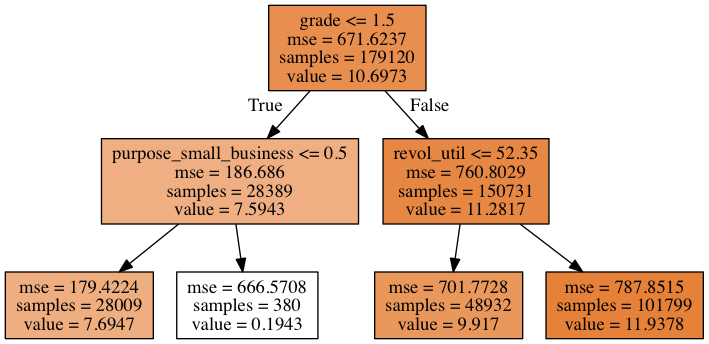

In [58]:
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt_roi, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

## Finding from regression

### If you are a risk taker investor and want maximum ROI, you should invest in the loan with HIGH revolving utilization 

<b> Validation</b> 

Adding pupose column from original dataframe as df_clean has dummies of purpose

In [59]:
df_clean['purpose']= df['purpose']

In [60]:
roi_proof = df_clean[['grade','ROI','purpose','revol_util']]

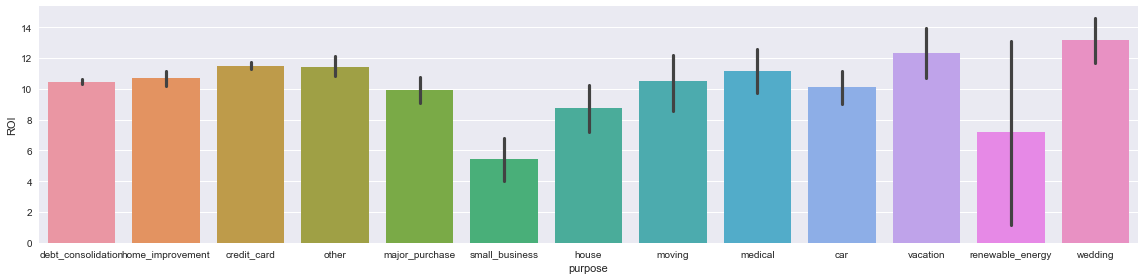

In [61]:
sns.factorplot(y='ROI', x='purpose' ,data=roi_proof, aspect=4,kind='bar')

In [62]:
roi_proof['revol_util'] = pd.cut(roi_proof['revol_util'],bins=[0.0,25.0,50.0,75.0,100.0,125.0])

/Users/purnima.tripathi/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


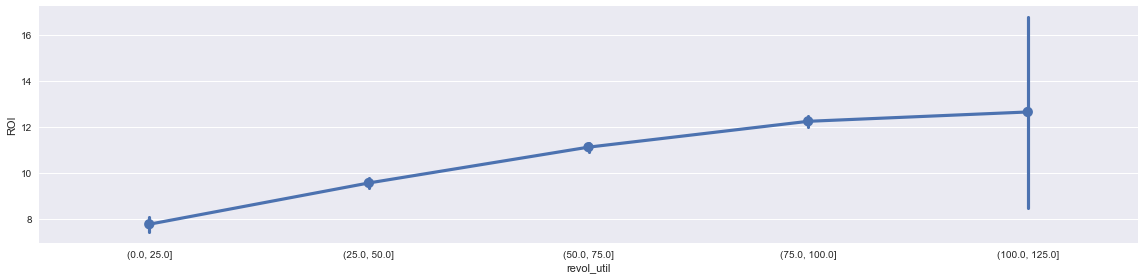

In [63]:
sns.factorplot(x='revol_util', y='ROI',data=roi_proof, aspect=4)

# Finding 3: Classification

Combine accepeted and rejected loan data and kept common columns

In [64]:
rejcted_df = pd.read_csv("Lending_Club_Reject_Loan_Data.csv", low_memory=False)
rdf = rejcted_df[['Amount Requested', 'Debt-To-Income Ratio', 'Employment Length']]
rejected = rdf.rename(columns={'Employment Length': 'emp_length', 'Amount Requested': 'loan_amnt', 'Debt-To-Income Ratio': 'dti'})
rejected['approved'] = 0.0
rejected['dti'] = rejected['dti'].str.replace('%', '').astype(np.float64) 

making emp_lengh same as approved data

In [65]:
rejected['emp_length'] = rejected.emp_length.replace({
    '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0,
        'n/a': 0})

In [66]:
approved = df_clean[['emp_length','loan_amnt', 'dti']]
approved['approved'] = 1.0

/Users/purnima.tripathi/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [67]:
loan_applications_df = pd.concat([approved, rejected])

In [68]:
dt_loan_apps = tree.DecisionTreeClassifier(max_depth=2)
X = loan_applications_df.drop(['approved'], axis=1)
Y = loan_applications_df['approved']
dt_loan_apps.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

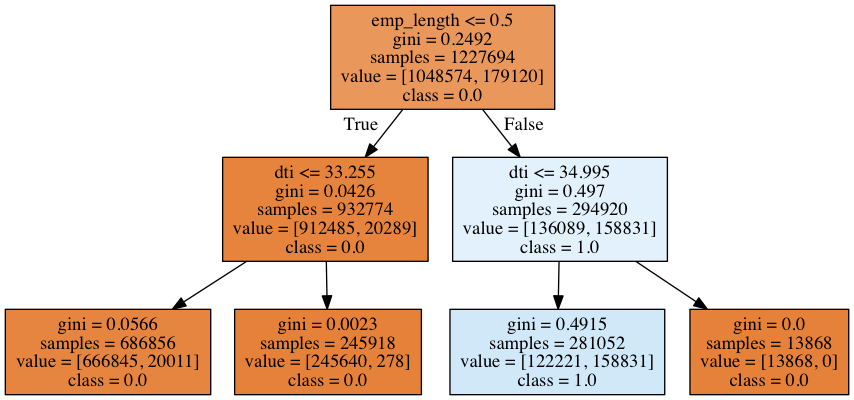

In [69]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt_loan_apps, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=['0.0', '1.0'],
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

## Finding from classification:
### To get a loan approved, borrower's DTI ratio should be less than 35.0 

###  Loan approval rate for borrowers having 1 or more years of employent is much higher compared to borrowers with less than 1 year.

<b> Validation</b>

Making two employment groups(Less than a year and 1 or grater than 1 year)

In [70]:
loan_applications_df['emp_length'] = loan_applications_df.emp_length.replace({
    10:1, 
    4:1, 
    2:1, 
    3:1, 
    7:1, 
    6:1,
    5:1, 
    9:1, 
    8:1, 
    1:1,
    0:0})

In [71]:
loan_applications_df['dti_bins'] = pd.cut(loan_applications_df['dti'],bins=[0.0,10.0,20.0,30.0,40.0,50.0,np.inf])

## Managerial Insight based on above finding
### To give insight to borrowers whose emp_lenght is less than a year based on finding , Lets make a decision tree

In [73]:
loans_df = pd.concat([approved,rejected])

selected loan data with employment length less than a year

In [74]:
loans_df = loans_df[((loans_df['emp_length'] == 0))]
loans_df['dti_range'] = pd.cut(loans_df['dti'], [0, 25, 50, 100, loans_df['dti'].max()], labels=['<=25', '26-50', '51-100', '>100'])
loans_df.dropna(inplace=True)

removed dti > 100 to limit the no. of dummy columns ( very less rows with dti grater than 100)

In [75]:
loans_df = loans_df[loans_df['dti_range'] != '>100']

In [76]:
loans_df_dummies = pd.get_dummies(loans_df,columns=['dti_range'])

In [77]:
dt_emp = tree.DecisionTreeClassifier(max_depth=2)
X = loans_df_dummies.drop(['approved', 'emp_length'], axis=1)
Y = loans_df_dummies['approved']
dt_emp.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

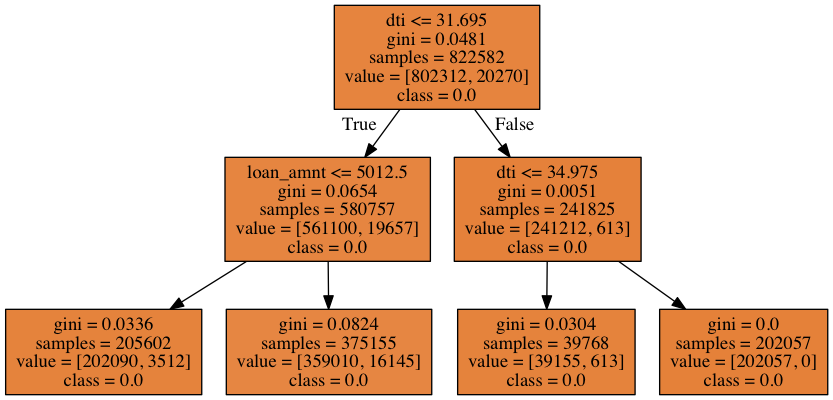

In [78]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt_emp, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=['0.0', '1.0'],
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

## Insight to borrowers with employment lenght less than a year: 

### To maximize the chances of loan approval, loan amount should be in range 5,000 - 15,0000. 

<b> validation of insight</b>

In [79]:
loans_df['loan_amount_range'] = pd.cut(loans_df['loan_amnt'], [0, 5000,10000,15000,20000,25000,30000, loans_df['loan_amnt'].max()])

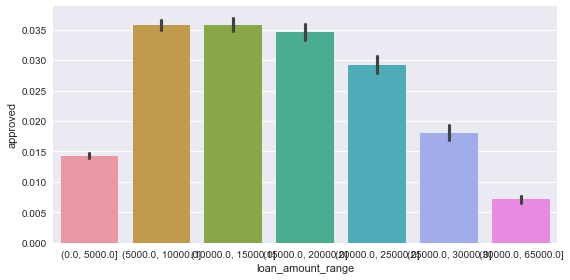

In [80]:
sns.factorplot(x='loan_amount_range',y='approved',data=loans_df,kind='bar',aspect=2)

### Past history of defaulted loans and traits of borrower can help investors make good decision for investments and optimize their return.

## Conclusion:
<b>From this analysis, we found some interesting tips for investors and borrowers:</b>

<b> Tips for Investors: </b>
<ui>
<li>Pay more attention on dti while investing in long term loans however it does not impact short term loans infact higher dti (higher return rate) in short term loans will maximize your profits.</li>
<li>If you are a risk taker and want to maximize your return, you should go for investing in loans that has higher revol_util rate but beware that loan may default!!</li>
</ui>

<b> Tips for Borrowers:</b>
<ui> <li>
If your employment length is 1 year and dti is greater than 35% then asking loan amount between 5000 to 15000 will brighten up your chances.
</li></ui>